<img src='https://raw.githubusercontent.com/autonomio/hyperio/master/logo.png'>

In [1]:
import sys
sys.path.insert(0, '/Users/mikko/Documents/GitHub/hyperio')

In [31]:
import hyperio as hy
import pandas as pd

%matplotlib inline

### 1. Data Preparation

For this experiment, we're going to use the famous Iris dataset. 

In [3]:
# for converting the Name to categorical, we'll use Keras

from keras.utils import to_categorical

def iris():

    '''
    Returns (x, y)

    '''

    df = pd.read_csv('iris.csv')
    df['Name'] = df['Name'].factorize()[0]
    df = df.sample(len(df))
    y = to_categorical(df['Name'])
    x = df.iloc[:,:-1].values

    return x, y

x, y = iris()

### 2. Model Preparation 
Hyperio works with any Keras model, without changing the structure of the model in anyway, or without introducing any new syntax. The below example shows clearly how this works. First we have to import two helper functions from Hyperio, one for early stopping callout, and the other for using normalized learning rate values. Because we might want to work on trying out several optimizers in a single scan, without normalization, inputting of the values would become cumbersome.

In [4]:
from hyperio import lr_normalizer, early_stopper

Note that the only difference in the model below is how instead of using a label or value to define a given model parameter, we do it using a dictionary label. Also for optimizer we are using a learning rate parameter, which involves the use of two dictionary labels. Finally, we're using a callback with a preset value 'strict'.

In [5]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

def iris_model(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()                            
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    activation='relu'))
    
    model.add(Dropout(params['dropout']))
    model.add(Dense(y_train.shape[1],
                    activation=params['last_activation']))

    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[x_val, y_val],
                    callbacks=early_stopper(params['epochs'], mode='strict'))
    
    return out

### 3. Setting the Parameter Space Boundaries
In the last and final step, we're going to create the dictionary, which will then be passed on to hyperio together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

For values we don't want to use, it's ok to set it as None.

NOTE: at this point you have to import from Keras the optimizer, activations, and losses you want to scan for.

In [6]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

p = {'lr': (2, 10, 30),
     'first_neuron':[4, 8, 16, 32, 64, 128],
     'batch_size': [2, 3, 4],
     'epochs': [500],
     'dropout': (0, 0.40, 10),
     'optimizer': [Adam, Nadam],
     'loss': [categorical_crossentropy, logcosh],
     'last_activation': [softmax],
     'weight_regulizer':[None],
     'emb_output_dims': [None]}

### 4. Running the Model
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Hyperio() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 1/100 of the entire permutations.

In [8]:
h = hy.Hyperio(x, y, params=p, dataset_name='iris', experiment_no='1', model=iris_model, grid_downsample=.01)

57 scans will take roughly 57 seconds
Scan Finished!


### 5. Accessing the hyperio object

In [9]:
# number of combinations with the selection
h.combinations

5760

In [10]:
# the results dataframe
h.result.head(3)

,train_peak,val_peak,train_acc,val_acc,train_loss,val_loss,train_score,val_score,batch_size,epochs,round_epochs,dropout,normalized_lr,first_neuron,loss,optimizer,last_activation,embed_dims,weight_regul
0,4,6,0.961905,0.955556,0.013299,0.016764,0.948606,0.938791,2,500,9,0.12,7,128,<function logcosh at 0x11e2be730>,<class 'keras.optimizers.Adam'>,<function softmax at 0x11e2debf8>,None,None
1,16,14,0.885714,0.933333,0.274503,0.254995,0.611211,0.678338,4,500,17,0.16,9,8,<function categorical_crossentropy at 0x11e2be...,<class 'keras.optimizers.Adam'>,<function softmax at 0x11e2debf8>,None,None
2,19,17,0.961905,0.977778,0.169008,0.137809,0.792897,0.839969,2,500,20,0.12,6,8,<function categorical_crossentropy at 0x11e2be...,<class 'keras.optimizers.Nadam'>,<function softmax at 0x11e2debf8>,None,None


Basically everything related with the experiment are stored in the object, so have a look around. But for now, let's move on. The other main functionality has to do with interpreting the results. For that we have separate command.

### 6. Analyzing the results
Because the analysis represents a different stage in the iterative process of hyperparameter optimization, it's separated to a different command. Actually there are just two commands in the Hyperio namespace 'Hyperio' which is for the setting up of the experiment and running it, and 'Reporting' which is for analyzing.

Let's start by loading a previous result with more observations, it's also for the Iris dataset.

In [3]:
r = hy.Reporting('iris_e.csv')


Model with the best val_score
------------------------------
The  highest val_score is 99.80%, which was achieved after 11 epochs using logcosh (loss), Adam (optimizer), and softmax (activation). The batch size was 2 with a dropout of 0 and a normalized learning rate of 8.00 and 64 first layer neurons.  
        

Model with the best train_score
------------------------------
The  highest val_score is 97.60%, which was achieved after 29 epochs using logcosh (loss), Adam (optimizer), and softmax (activation). The batch size was 2 with a dropout of 0 and a normalized learning rate of 3.00 and 16 first layer neurons.  
        


,first_neuron,batch_size,round_epochs,normalized_lr,optimizer,last_activation,loss
val_score,,,,,,,
0.998,64,3,10,8,Nadam,softmax,logcosh
0.998,128,3,19,5,Adam,softmax,logcosh
0.998,64,2,13,6,Nadam,softmax,logcosh
0.998,64,2,14,8,Adam,softmax,logcosh
0.998,16,2,17,8,Nadam,softmax,logcosh
0.997,16,4,17,7,Nadam,softmax,logcosh
0.997,64,2,22,5,Adam,softmax,logcosh
0.997,32,3,20,7,Nadam,softmax,logcosh
0.997,128,2,11,4,Nadam,softmax,logcosh


,first_neuron,batch_size,round_epochs,normalized_lr,optimizer,last_activation,loss
val_score,,,,,,,
-1.115,128,4,12,6,Nadam,softmax,categorical_crossentropy
-1.114,128,4,12,4,Nadam,softmax,categorical_crossentropy
-0.926,128,2,5,7,Nadam,softmax,categorical_crossentropy
-0.858,128,4,8,9,Nadam,softmax,categorical_crossentropy
-0.838,8,4,5,5,Nadam,softmax,categorical_crossentropy
-0.836,4,3,8,3,Nadam,softmax,categorical_crossentropy
-0.821,4,2,19,3,Adam,softmax,categorical_crossentropy
-0.768,4,2,7,8,Nadam,softmax,categorical_crossentropy
-0.768,4,2,16,5,Adam,softmax,categorical_crossentropy



 NOTE: you have more options in the Reporting object.



In addition to the default report, we have several options.

In [5]:
# gives the dictionary for top result params
r.top_params

{'batch_size': (2, 4),
 'epochs': (2, 500),
 'dropout': (0.0, 0.36),
 'normalized_lr': (2, 9),
 'embed_dims': ('None', 'None'),
 'weight_regul': ('None', 'None'),
 'loss': ['logcosh', 'categorical_crossentropy'],
 'optimizer': ['Nadam', 'Adam'],
 'last_activation': ['softmax']}

In [4]:
# gives the dictionary for bottom result params
r.bottom_params

{'batch_size': (2, 4),
 'epochs': (2, 500),
 'dropout': (0.0, 0.36),
 'normalized_lr': (2, 9),
 'embed_dims': ('None', 'None'),
 'weight_regul': ('None', 'None'),
 'loss': ['logcosh', 'categorical_crossentropy'],
 'optimizer': ['Nadam', 'Adam'],
 'last_activation': ['softmax']}

In [6]:
# access the dataframe
r.data.head(3)

,train_peak,val_peak,train_acc,val_acc,train_loss,val_loss,train_score,val_score,batch_size,epochs,round_epochs,dropout,normalized_lr,first_neuron,loss,optimizer,last_activation,embed_dims,weight_regul
0,17,17,0.933,1.000,0.218,0.106,0.715,0.894,2,500,20,0.32,6,32,categorical_crossentropy,Adam,softmax,None,None
1,35,35,0.952,1.000,0.243,0.139,0.709,0.861,3,500,38,0.16,5,8,categorical_crossentropy,Adam,softmax,None,None
2,4,4,0.924,0.978,0.026,0.017,0.897,0.961,3,500,7,0.04,7,32,logcosh,Nadam,softmax,None,None


In addition, we have several useful plotting options.

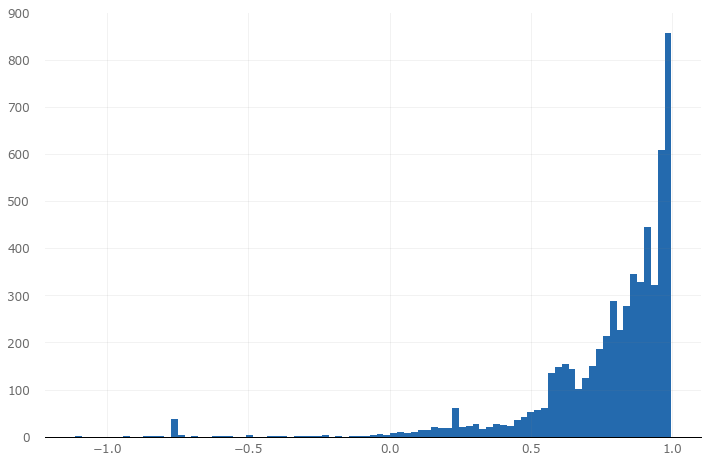

In [9]:
r.plots.hist(r.data, 'val_score')

There are in total more than 20 plots with completely unified, production quality look. Each plot has a more or less unified parameter space, which focus on the aesthetic aspect.

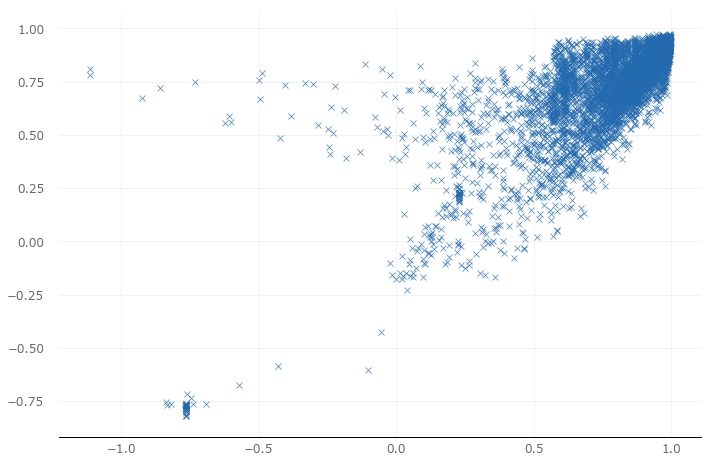

In [10]:
r.plots.regs(r.data, 'val_score', 'train_score')

It's very easy to add titles and other visual attributes to your plots.

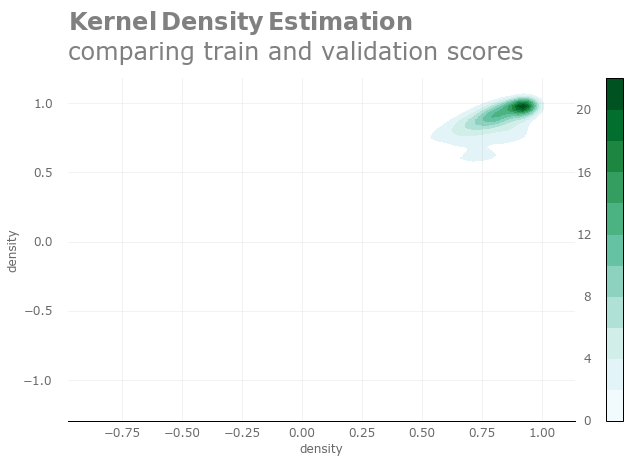

In [24]:
r.plots.kde(r.data, 'train_score', 'val_score',
            title='Kernel Density Estimation',
            sub_title='comparing train and validation scores',
            x_label='density',
            y_label='density',
            palette='default')

There are several options that are particularly useful for analyzing hyperparamater scanning results.

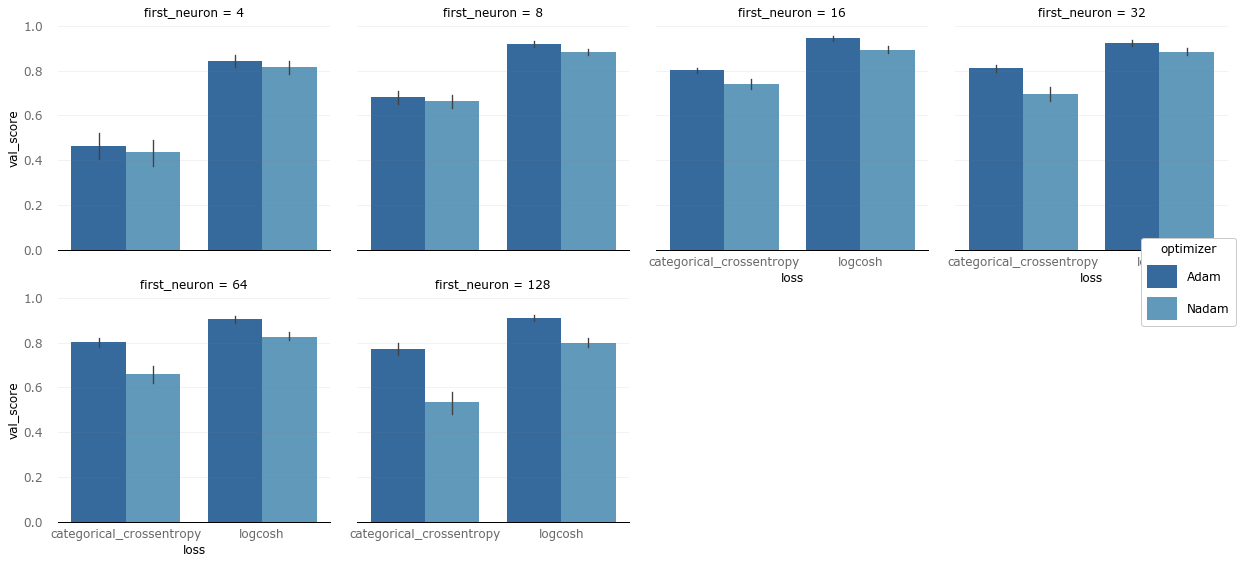

In [27]:
r.plots.bargrid(r.data, x='loss',y='val_score', hue='optimizer', col='first_neuron', col_wrap=4)

### 7. Accessing your results later 
Based on the inputs you had provided in the Hyperio() run 'dataset_name' and 'experiment_no' a file will be created in the local folder. In this case you would access it by:

In [ ]:
hy.Reporting('iris_1.csv')

In addition, a master log file is created, which by default is called hyperio.log, where the results of every round, for every dataset and experiment is saved. This way you have a full record of every scan you run complete with Hyperio. 

In [30]:
pd.read_csv('hyperio.log', header=None).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5,64,2,2,0.04,'Nadam','categorical_crossentropy','softmax','None','None',0.436,2,category,3,onehot,0.3,iris
1,2,32,2,2,0.24,'Adam','categorical_crossentropy','softmax','None','None',-0.100,2,category,3,onehot,0.3,iris
2,8,4,4,2,0.32,'Nadam','logcosh','softmax','None','None',0.403,2,category,3,onehot,0.3,iris
3,6,128,2,2,0.24,'Adam','logcosh','softmax','None','None',0.425,2,category,3,onehot,0.3,iris
4,5,4,2,2,0.20,'Nadam','logcosh','softmax','None','None',0.245,2,category,3,onehot,0.3,iris


It includes information about each parameter used in the round, and the type of dataset in question.


<img align=left src='https://img00.deviantart.net/920c/i/2014/137/a/2/pinkie_pie_thats_all_folks_by_dan232323-d7ipnd4.jpg' width=400>

Back to the repository page >> http://github.com/autonomio/hyperio